<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Support-code" data-toc-modified-id="Support-code-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Support code</a></span></li><li><span><a href="#read_execute_model.py" data-toc-modified-id="read_execute_model.py-3"><span class="toc-item-num">3&nbsp;&nbsp;</span><code>read_execute_model.py</code></a></span></li><li><span><a href="#Load-data" data-toc-modified-id="Load-data-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Load data</a></span></li><li><span><a href="#Load-data" data-toc-modified-id="Load-data-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Load data</a></span></li><li><span><a href="#Load-model" data-toc-modified-id="Load-model-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Load model</a></span></li></ul></div>

----

----

In [26]:
%load_ext watermark
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    %watermark -v -m -p numpy,scipy,pandas,matplotlib,seaborn,sklearn,lightgbm,shap
# https://github.com/rasbt/watermark

import os; print('Running on conda environment "%s", located at "%s".' % (
    os.environ['CONDA_DEFAULT_ENV'], os.environ['CONDA_PREFIX']))

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Python implementation: CPython
Python version       : 3.11.10
IPython version      : 9.1.0

numpy     : 1.24.4
scipy     : 1.13.1
pandas    : 2.2.2
matplotlib: 3.9.2
seaborn   : 0.13.2
sklearn   : 1.5.2
lightgbm  : 3.3.5
shap      : 0.46.0

Compiler    : MSC v.1941 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 165 Stepping 2, GenuineIntel
CPU cores   : 12
Architecture: 64bit

Running on conda environment "mla_202411", located at "C:\Users\lfs\miniforge3\envs\mla_202411".


----

# Imports

In [2]:
import os

In [ ]:
import numpy as np
import pandas as pd

In [12]:
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns

%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 8
plt.rcParams['figure.facecolor'] = 'w'  # remove the default background transparency

In [13]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_colwidth', 100)

In [14]:
from fastprogress import master_bar, progress_bar

In [15]:
from scipy.stats import percentileofscore

----

----

# Support code

**`evaluate()`**

See notes on [Discord 2022-10-03](https://discord.com/channels/697086816985284638/700734762545053757/1026439100267515944) about ways to define the decision threshold through `cut_prob` or `num_in_target`. In particular see notes on [Discord 2022-10-04](https://discord.com/channels/697086816985284638/700734762545053757/1026880593679614015) for consequences of setting the threshold through the recommended default of `num_in_target=y_true.mean()` ("I know there are 10% of true targets in the train set, so give me the threshold that leaves me with 10% predictions getting the positive binary prediction label").

In [8]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix


def evaluate(y_true_class, y_pred_score, num_in_target=None, cut_prob=None, round_evals=True):
    """
    Apply a batch of classification metrics to evaluate the performance of a
    model that tries to predict the true binary target in `y_true_class`, by
    assigning samples the probabilities in `y_pred_score`.

    For the metrics that require a predicted class, instead of a probability,
    the parameters `cut_prob` and `num_in_target` control the class assignment.
    Samples with a `y_pred_score >= cut_prob` receive a class=1. If the
    probability cutoff `cut_prob` is undefined, the `num_in_target` rows with
    greatest probability receive a class=1. Should `num_in_target` be a value in
    [0, 1], that fraction of samples with greatest probability gets a class=1.

    See also:
    https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics
    https://en.wikipedia.org/wiki/Confusion_matrix
    """
    if cut_prob is None:
        if num_in_target is None:
            num_in_target = y_true_class.mean()
        if num_in_target < 1:
            num_in_target = int(round(num_in_target * len(y_pred_score)))
        decr_y_score = y_pred_score.sort_values(ascending=False)
        cut_prob = decr_y_score.iloc[num_in_target - 1]
    
    # apply a probability cutoff to assign the binary classes
    y_pred_class = (y_pred_score >= cut_prob).astype(int)
    num_in_target = y_pred_class.sum()
    
    thr_pct = percentileofscore(y_pred_score, cut_prob) / 100
    neg_pred_mean = y_pred_score[y_pred_score < cut_prob].mean()
    
    
    roc_auc = roc_auc_score(y_true_class, y_pred_score)
    
    # summarizes a precision-recall curve as the weighted mean of precisions
    # achieved at each threshold, with the increase in recall from the previous
    # threshold used as the weight
    ap = average_precision_score(y_true_class, y_pred_score)
    
    
    conf_matrix = confusion_matrix(y_true_class, y_pred_class)
    (tn, fp), (fn, tp) = conf_matrix
    
    assert (tp + fn) == y_true_class.sum() #[0] # samples that truly are in the target
    assert (tp + fp) == num_in_target         # samples model places in the target
    
    # precision or positive predictive value (PPV)
    precision = tp / (tp + fp)
    # in a marketing campaign: it's the expected conversion rate
    # true_positives / num_in_target
    
    # sensitivity, recall, hit rate, or true positive rate (TPR)
    recall = tp / (tp + fn)
    # in a marketing campaign: fraction of clients who converted
    # (positive target) that can be found among the campaign's targets
    # true_positives / total_positives
    
    # specificity, selectivity or true negative rate (TNR)
    # proportion of actual negatives that are correctly identified as such
    specificity = tn / (tn + fp)
    
    # Negative Predictive Value
    # equivalent to precision, but for the prediction of negatives
    NPV = tn / (tn + fn)
    
    # False Omission Rate (= 1 - NPV)
    FOR = fn / (fn + tn)
    FOR_lift = FOR / ((fn + tp) / (fn + tp + tn + fp))
    
    # proportion of true results (both true positives and true negatives)
    # among the total number of cases examined
    accuracy = (tp + tn) / conf_matrix.sum()
    
    # F-score, measure of a test's accuracy. It's the harmonic mean of the
    # precision and recall, where an F1 score reaches its best value at 1
    # (perfect precision and recall) and worst at 0. F_2 variant: weighs
    # recall higher than precision (places more emphasis on false negatives)
    b = 1; F_1 = (1 + b*b) * precision * recall / (b*b * precision + recall)
    b = 2; F_2 = (1 + b*b) * precision * recall / (b*b * precision + recall)
    
    # how many more times are we more likely to find true positives among the
    # samples the model classifies as true, than if we were to pick at random
    precision_lift = precision / y_true_class.mean() #[0]
    
    
    evals = (
        ('roc_auc'           , roc_auc),
        ('average_precision' , ap),
        ('precision_lift'    , precision_lift),
        ('precision'         , precision),
        ('recall'            , recall),
        ('TNR (neg. recall)' , specificity),
        ('NPV (neg. precis.)', NPV),
        ('FOR (default rate)', FOR),
        ('FOR_lift'          , FOR_lift),
        ('F1'                , F_1),
        ('F2'                , F_2),
        ('accuracy'          , accuracy),
        #('confusion_matrix'  , conf_matrix),
        ('tn'                , tn),
        ('fp'                , fp),
        ('fn'                , fn),
        ('tp'                , tp),
        ('base_rate'         , y_true_class.mean()),
        ('class_threshold'   , cut_prob),
        ('nr_in_target tp+fp', tp + fp),
        ('true_targets tp+fn', tp + fn),
        ('threshold_pcentile', thr_pct),
        ('neg_pred_mean'     , neg_pred_mean),
        )
    
    evals = pd.Series(*zip(*[(v, k) for (k, v) in evals]))
    
    return evals.round(4) if round_evals else evals

In [9]:
def best_cutoff(
        y_true_class, y_pred_score, max_metric=None,
        #tn_cost=None, fp_cost=None, fn_cost=None, tp_cost=None
        ):
    """
    Computes the best cut off for the model given the true prediction values
    "y_true_class" and the prediction scores "y_pred_score".
    Optionally, one can define one metric to maximize.
    This function is built on top of the 'evaluate()' function.
    """
    metrics_df = pd.DataFrame([])

    with np.errstate(invalid='ignore'):
        for i in np.linspace(0, 1, 101):
            metrics = evaluate(
                y_true_class, y_pred_score, cut_prob=i,
                #tn_cost=tn_cost, fp_cost=fp_cost, fn_cost=fn_cost, tp_cost=tp_cost
                round_evals=False)
            
            metrics_df = pd.concat([metrics_df, metrics], axis=1)

    metrics_df = metrics_df.T
    metrics_df.index = np.linspace(0, 1, 101)

    if max_metric == None:
        return metrics_df
    else:
        return metrics_df[metrics_df[max_metric] == metrics_df[max_metric].max()].T

In [10]:
from sklearn.model_selection import StratifiedShuffleSplit


def monte_carlo_cv(X, y, model, n_splits=100, test_size=0.2, random_state=0, threshold=None, max_metric=None, progbar=True):
    
    sss = StratifiedShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=random_state)
    
    iterator = sss.split(X,y)
    if progbar:
        iterator = progress_bar(iterator, total=n_splits)
    
    evals = []
    
    for train_index, test_index in iterator:
        
        X_train = X.iloc[train_index]
        y_train = y.iloc[train_index]
        X_test  = X.iloc[ test_index]
        y_test  = y.iloc[ test_index]
        
        model.fit(X_train, y_train)
        
        y_test_pred = model.predict_proba(X_test)[:,1]
        
        if max_metric is None:
            threshold_ = dict(num_in_target=y_test.mean()) if threshold is None else dict(cut_prob=threshold)
            m_eval = evaluate(y_test, pd.Series(y_test_pred), round_evals=False, **threshold_)
        else:
            y_train_pred = model.predict_proba(X_train)[:,1]
            train_eval = best_cutoff(y_train, pd.Series(y_train_pred), max_metric).T.iloc[0].T
            # apply over the test set the threshold optimized in the train set
            m_eval = evaluate(y_test, pd.Series(y_test_pred), cut_prob=train_eval['class_threshold'], round_evals=False)
        
        evals.append(m_eval)
    
    return evals

In [11]:
def null_stats(df):
    """
    Statistics on the number and percentage of missing values.
    """
    df = df.to_frame() if isinstance(df, pd.Series) else df
    isnull_sum = df.isnull().sum()
    isnull_pct = isnull_sum / len(df) * 100

    isnull_sum.name = '# NaN'
    isnull_pct.name = '% NaN'

    return pd.concat([isnull_sum, isnull_pct], axis=1)

----

----

# `read_execute_model.py`

O que está pensado neste momento é que o código desta secção seja o template dado ao cliente que especifica a forma como os seus dados podem ser lidos, e modelo executado sobre eles. Caso os dados ou modelo tenham necessidades de processamento diferentes, cliente pode então especifica-las via ajustes a este código.

Dumping the code from:
    
    MVP\datasets\PD_CC_20210917\read_execute_model_v2.py
    
    
See discussion from 2021-10-08:
* https://discord.com/channels/697086816985284638/700743914692411462/895987915597963294

In [12]:
import pickle
import pandas as pd


def load(fname, mode='rb', open=open):
    with open(fname, mode) as f:
        d = pickle.load(f)
    return d


def encode(data_file, data_dict_file):
    d = pd.read_excel(data_dict_file)
    index_cols = list(d['feature'][d['feature_type'] == 'index'])
    input_cols = list(d['feature'][d['feature_type'] == 'input'])
    target_col = list(d['feature'][d['feature_type'] == 'target'])
    categ_cols = list(d['feature'][d['data_type'] == 'category'])
    
    X = pd.read_csv(data_file)
    if index_cols != []: X.set_index(index_cols, inplace=True)
    
    assert len(target_col) == 1
    y = X[target_col[0]]
    
    X = X[input_cols] # enforce column ordering
    X[categ_cols] = X[categ_cols].astype('category')
    
    return X, y


def predict(model, X):
    if isinstance(model, str):
        model = load(model)
    
    y = pd.DataFrame(model.predict_proba(X)).iloc[:,1]
    
    if isinstance(X, pd.DataFrame):
        y.index = X.index
    
    return y

----

----

# Load data

Dataset:

**GiveMeSomeCredit** ~~ https://www.kaggle.com/competitions/GiveMeSomeCredit/overview

> **Improve on the state of the art in credit scoring by predicting the probability that somebody will experience financial distress in the next two years.**


> Banks play a crucial role in market economies. They decide who can get finance and on what terms and can make or break investment decisions. For markets and society to function, individuals and companies need access to credit. 
> 
> Credit scoring algorithms, which make a guess at the probability of default, are the method banks use to determine whether or not a loan should be granted. This competition requires participants to improve on the state of the art in credit scoring, by predicting the probability that somebody will experience financial distress in the next two years.
> 
> The goal of this competition is to build a model that borrowers can use to help make the best financial decisions.

In [13]:
from zipfile import ZipFile

In [14]:
with ZipFile('outputs/ls 01/dataset/GiveMeSomeCredit.zip', 'r') as zf:
    
    with zf.open('cs-training.csv', mode='r') as f:
        dataset_raw = pd.read_csv(f)
        
    with zf.open('Data Dictionary.xls', mode='r') as f:
        data_dict_raw = pd.read_excel(f, header=1)

Configuration of desired transformations to the feature names, and their ordering.

In [15]:
# Mapping adapted from:
# https://gitlab.mlanalytics.pt/ml-analytics/mvp/research/-/blob/705fd2d6e183be097400bc036d77177cd04c1b7a/src/mvp/dataset.py#L34

# transform from CamelCase to Snake case
column_mapping = {
    'MonthlyIncome'                        : 'monthly_income',
    'DebtRatio'                            : 'debt_ratio',
    'NumberOfDependents'                   : 'nr_dependents',
    'RevolvingUtilizationOfUnsecuredLines' : 'credit_balances_dividedby_limits',
    'NumberOfOpenCreditLinesAndLoans'      : 'nr_open_credit_lines_and_loans',
    'NumberRealEstateLoansOrLines'         : 'nr_real_estate_loans',
    'NumberOfTime30-59DaysPastDueNotWorse' : 'nr_times_30_59_days_past_due',
    'NumberOfTime60-89DaysPastDueNotWorse' : 'nr_times_60_89_days_past_due',
    'NumberOfTimes90DaysLate'              : 'nr_times_90plus_days_past_due',
    'SeriousDlqin2yrs'                     : 'serious_delinquency',
    }

Data preparation: data dictionary

In [16]:
data_dict = data_dict_raw.copy()

# rename the variable names, and enforce the desired ordering
data_dict['Variable Name'] = data_dict['Variable Name'].map(column_mapping)
data_dict = data_dict.set_index('Variable Name').loc[list(column_mapping.values())]

# add the `feature_type` column, with the format expected by the `encode()` function above
data_dict['feature_type'] = 'input'
data_dict.loc['serious_delinquency', 'feature_type'] = 'target'

data_dict.index.name = 'feature'
data_dict.columns = ['description', 'data_type', 'feature_type']

data_dict

,description,data_type,feature_type
feature,,,
monthly_income,Monthly income,real,input
debt_ratio,"Monthly debt payments, alimony,living costs divided by monthy gross income",percentage,input
nr_dependents,"Number of dependents in family excluding themselves (spouse, children etc.)",integer,input
credit_balances_dividedby_limits,Total balance on credit cards and personal lines of credit except real estate and no installment...,percentage,input
nr_open_credit_lines_and_loans,Number of Open loans (installment like car loan or mortgage) and Lines of credit (e.g. credit ca...,integer,input
nr_real_estate_loans,Number of mortgage and real estate loans including home equity lines of credit,integer,input
nr_times_30_59_days_past_due,Number of times borrower has been 30-59 days past due but no worse in the last 2 years.,integer,input
nr_times_60_89_days_past_due,Number of times borrower has been 60-89 days past due but no worse in the last 2 years.,integer,input
nr_times_90plus_days_past_due,Number of times borrower has been 90 days or more past due.,integer,input


Data preparation: dataset

In [17]:
# drop index column [it's just a 1-based sequential indexing]
dataset = dataset_raw.drop(columns='Unnamed: 0')

# rename columns, and enforce the desired ordering
dataset = dataset.rename(columns=column_mapping)[list(column_mapping.values())]

In [18]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 10 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   monthly_income                    120269 non-null  float64
 1   debt_ratio                        150000 non-null  float64
 2   nr_dependents                     146076 non-null  float64
 3   credit_balances_dividedby_limits  150000 non-null  float64
 4   nr_open_credit_lines_and_loans    150000 non-null  int64  
 5   nr_real_estate_loans              150000 non-null  int64  
 6   nr_times_30_59_days_past_due      150000 non-null  int64  
 7   nr_times_60_89_days_past_due      150000 non-null  int64  
 8   nr_times_90plus_days_past_due     150000 non-null  int64  
 9   serious_delinquency               150000 non-null  int64  
dtypes: float64(4), int64(6)
memory usage: 11.4 MB


In [19]:
null_stats(dataset)

,# NaN,% NaN
monthly_income,29731,19.820667
debt_ratio,0,0.000000
nr_dependents,3924,2.616000
credit_balances_dividedby_limits,0,0.000000
nr_open_credit_lines_and_loans,0,0.000000
nr_real_estate_loans,0,0.000000
nr_times_30_59_days_past_due,0,0.000000
nr_times_60_89_days_past_due,0,0.000000
nr_times_90plus_days_past_due,0,0.000000
serious_delinquency,0,0.000000


In [20]:
dataset.head().T.round(2)

,0,1,2,3,4
monthly_income,9120.00,2600.00,3042.00,3300.00,63588.00
debt_ratio,0.80,0.12,0.09,0.04,0.02
nr_dependents,2.00,1.00,0.00,0.00,0.00
credit_balances_dividedby_limits,0.77,0.96,0.66,0.23,0.91
nr_open_credit_lines_and_loans,13.00,4.00,2.00,5.00,7.00
nr_real_estate_loans,6.00,0.00,0.00,0.00,1.00
nr_times_30_59_days_past_due,2.00,0.00,1.00,0.00,1.00
nr_times_60_89_days_past_due,0.00,0.00,0.00,0.00,0.00
nr_times_90plus_days_past_due,0.00,0.00,1.00,0.00,0.00
serious_delinquency,1.00,0.00,0.00,0.00,0.00


----

Write the DataFrames:

In [27]:
data_path      = r'outputs/ls 01/'

data_file      = data_path + 'GiveMeSomeCredit__dataset.csv'
data_dict_file = data_path + 'GiveMeSomeCredit__data_dictionary.xlsx'
model_file     = data_path + 'GiveMeSomeCredit__model.pkl'

In [22]:
#dataset.to_csv(data_file, index=False)

In [23]:
#data_dict.to_excel(data_dict_file)

----

----

# Load data

In [24]:
X, y_true = encode(data_file, data_dict_file)

In [25]:
X.shape

(150000, 9)

In [26]:
y_true.shape

(150000,)

In [27]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 9 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   monthly_income                    120269 non-null  float64
 1   debt_ratio                        150000 non-null  float64
 2   nr_dependents                     146076 non-null  float64
 3   credit_balances_dividedby_limits  150000 non-null  float64
 4   nr_open_credit_lines_and_loans    150000 non-null  int64  
 5   nr_real_estate_loans              150000 non-null  int64  
 6   nr_times_30_59_days_past_due      150000 non-null  int64  
 7   nr_times_60_89_days_past_due      150000 non-null  int64  
 8   nr_times_90plus_days_past_due     150000 non-null  int64  
dtypes: float64(4), int64(5)
memory usage: 10.3 MB


In [28]:
null_stats(X)

,# NaN,% NaN
monthly_income,29731,19.820667
debt_ratio,0,0.000000
nr_dependents,3924,2.616000
credit_balances_dividedby_limits,0,0.000000
nr_open_credit_lines_and_loans,0,0.000000
nr_real_estate_loans,0,0.000000
nr_times_30_59_days_past_due,0,0.000000
nr_times_60_89_days_past_due,0,0.000000
nr_times_90plus_days_past_due,0,0.000000


In [29]:
y_true

0         1
1         0
2         0
3         0
4         0
         ..
149995    0
149996    0
149997    0
149998    0
149999    0
Name: serious_delinquency, Length: 150000, dtype: int64

In [30]:
y_true.mean()

0.06684

**Handling missing values**. The validation approach below doesn't support missing values yet, so we need to impute them.

Two features have missing values in this dataset, `monthly_income` and `nr_dependents`.
When training with NaNs, we see in the shap dependence plots that `monthly_income == NaN` has shaps very similar to `monthly_income == 0`. In the case of `nr_dependents` the NaNs have a unique profile distinct from the other options (integer values). So, a fillna(-1) seems like an addequate choice for both cases.

In [31]:
X.fillna(-1, inplace=True)

---

# Load model

Here we'd normally load the pre-trained model we wish to validate. In this case we're training a fresh model over the dataset.

In [ ]:
from lightgbm import LGBMClassifier

In [ ]:
model = LGBMClassifier(random_state=42)
# Train set metrics
model.fit(X, y_true)
yp = model.predict_proba(X)[:,1]
ev = evaluate(y_true, pd.Series(yp), num_in_target=y_true.mean()); #ev

# Monte-Carlo CV metrics
evals = monte_carlo_cv(X, y_true, model, n_splits=100, test_size=0.2, random_state=0, progbar=True)
#print(pd.concat(evals, axis=1).agg(['mean', 'std'], axis=1).round(5))

evals_table = pd.concat([
    ev.rename(''),
    pd.concat(evals, axis=1).agg(['mean', 'std'], axis=1)
    ], keys=['Train_set', '  Monte-Carlo CV'], axis=1).round(4)

print(evals_table.round(4))

                      Train_set   Monte-Carlo CV         
                                            mean      std
roc_auc                  0.8845           0.8618   0.0040
average_precision        0.4663           0.3955   0.0104
precision_lift           7.0896           6.5451   0.1214
precision                0.4739           0.4374   0.0081
recall                   0.4739           0.4374   0.0081
TNR (neg. recall)        0.9623           0.9597   0.0006
NPV (neg. precis.)       0.9623           0.9597   0.0006
FOR (default rate)       0.0377           0.0403   0.0006
FOR_lift                 0.5638           0.6028   0.0087
F1                       0.4739           0.4374   0.0081
F2                       0.4739           0.4374   0.0081
accuracy                 0.9297           0.9248   0.0011
tn                  134699.0000       26867.0300  16.2763
fp                    5275.0000        1127.9700  16.2763
fn                    5275.0000        1127.9300  16.2526
tp            

Model is as of now trained over a Monte-Carlo CV train fold. Retrain over full train set.

In [34]:
model.fit(X, y_true)

yp = model.predict_proba(X)[:,1]

#dump(model, model_file)

In [35]:
#model.steps[0][1].__dict__
#model.steps[1][1].__dict__
model.__dict__

{'boosting_type': 'gbdt',
 'objective': None,
 'num_leaves': 31,
 'max_depth': -1,
 'learning_rate': 0.1,
 'n_estimators': 100,
 'subsample_for_bin': 200000,
 'min_split_gain': 0.0,
 'min_child_weight': 0.001,
 'min_child_samples': 20,
 'subsample': 1.0,
 'subsample_freq': 0,
 'colsample_bytree': 1.0,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'random_state': 42,
 'n_jobs': -1,
 'silent': True,
 'importance_type': 'split',
 '_Booster': <lightgbm.basic.Booster at 0x1bfc105d3d0>,
 '_evals_result': None,
 '_best_score': defaultdict(collections.OrderedDict, {}),
 '_best_iteration': None,
 '_other_params': {},
 '_objective': 'binary',
 'class_weight': None,
 '_class_weight': None,
 '_class_map': {0: 0, 1: 1},
 '_n_features': 9,
 '_n_features_in': 9,
 '_classes': array([0, 1], dtype=int64),
 '_n_classes': 2,
 '_le': LabelEncoder(),
 '_fobj': None,
 'fitted_': True}

----

**SHAP**

In [36]:
savepath = data_path + 'shap/'

os.makedirs(savepath, exist_ok=True)

In [37]:
import shap

from shap import explainers
from shap import maskers

In [38]:
%%time

expl_m = model
expl_x = X

# expl   = explainers.Tree(expl_m, data=expl_x, max_samples=10000, feature_perturbation="interventional"     )
expl_2 = explainers.Tree(expl_m,              max_samples=10000, feature_perturbation="tree_path_dependent")
# Currently TreeExplainer can only handle models with categorical splits when feature_perturbation="tree_path_dependent" and
# no background data is passed. Please try again using shap.TreeExplainer(model, feature_perturbation="tree_path_dependent").

# shap_df = pd.DataFrame(
#     expl.shap_values(expl_x),
#     index=expl_x.index, columns=expl_x.columns)

shap_df = shap_df_2 = pd.DataFrame(
    expl_2.shap_values(expl_x)[1],
    index=expl_x.index, columns=expl_x.columns)

Wall time: 16.7 s


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [39]:
expl_2.__dict__

{'model': <shap.explainers._tree.TreeEnsemble at 0x1bfc10829d0>,
 'output_names': None,
 'feature_names': None,
 'masker': None,
 'link': CPUDispatcher(<function identity at 0x000001BFBEB72A60>),
 'data': None,
 'data_missing': None,
 'feature_perturbation': 'tree_path_dependent',
 'expected_value': [3.5473943581777463, -3.5473943581777463],
 'model_output': 'raw'}

In [40]:
shap_df.shape

(150000, 9)

In [41]:
shap_df

,monthly_income,debt_ratio,nr_dependents,credit_balances_dividedby_limits,nr_open_credit_lines_and_loans,nr_real_estate_loans,nr_times_30_59_days_past_due,nr_times_60_89_days_past_due,nr_times_90plus_days_past_due
0,-0.004359,0.359330,0.066847,0.942201,0.074025,0.676039,1.246653,-0.054955,-0.097453
1,0.193499,-0.035657,0.070151,1.589959,-0.219842,0.086857,-0.211404,-0.067073,-0.141618
2,0.136088,-0.049383,-0.057515,0.673998,-0.075799,0.079934,0.522705,-0.130244,1.685949
3,0.232349,0.001572,-0.069351,-0.005227,-0.229346,0.124609,-0.179183,-0.048028,-0.106136
4,0.029465,0.215183,-0.034775,1.502113,-0.034572,-0.050920,0.840832,-0.093374,-0.130604
...,...,...,...,...,...,...,...,...,...
149995,0.207852,-0.119480,-0.075010,-0.844952,-0.223515,-0.122751,-0.187868,-0.047703,-0.109329
149996,0.048694,0.299585,0.103897,-0.004263,-0.150676,-0.090063,-0.177478,-0.053279,-0.106965
149997,-0.464825,0.297009,-0.037845,-0.066477,0.285614,-0.112777,-0.169599,-0.048552,-0.101228
149998,-0.119493,-0.502157,-0.043255,-0.570765,-0.272098,0.018637,-0.170861,-0.045004,-0.098954


In [42]:
expected_value = expl_2.expected_value[1]
expected_value

-3.5473943581777463

In [43]:
from scipy.special import expit, logit

# a logistic function applied over sum of shap values + expected_value == model's predicted probability
assert np.allclose(yp, expit(expected_value + shap_df.sum(axis=1)))

In [44]:
feature_relevance = shap_df.abs().mean(axis=0)
feature_relevance_sort = feature_relevance.sort_values(ascending=False)
feature_relevance_sort

credit_balances_dividedby_limits    0.754986
nr_times_30_59_days_past_due        0.316555
nr_times_90plus_days_past_due       0.216719
monthly_income                      0.189187
debt_ratio                          0.185532
nr_open_credit_lines_and_loans      0.156362
nr_times_60_89_days_past_due        0.120213
nr_real_estate_loans                0.094709
nr_dependents                       0.066190
dtype: float64

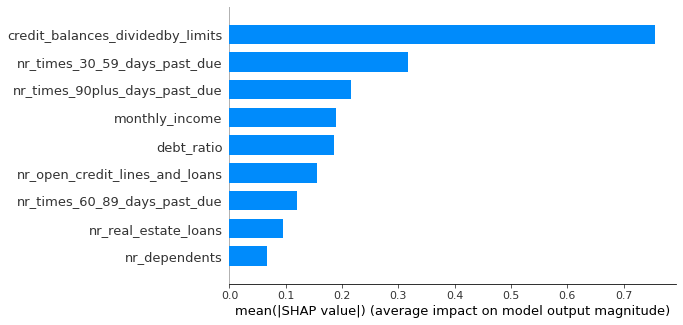

In [45]:
shap.summary_plot(shap_df, expl_x, max_display=25, plot_type='bar', show=False)
#plt.savefig(savepath + 'shap summary_plot (bar).png', dpi=150, bbox_inches='tight')

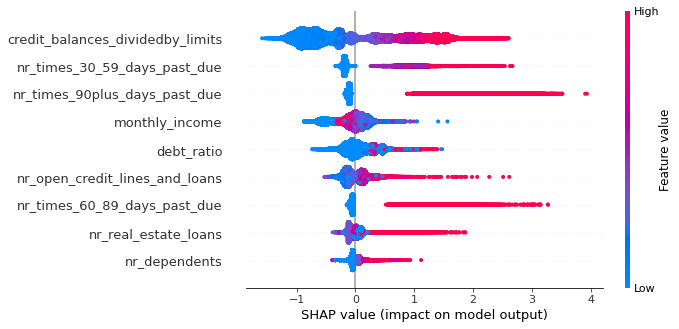

In [46]:
shap.summary_plot(
    shap_df.values,
    expl_x, #.values,
    #feature_names=shap_df.columns,
    max_display=25,
    sort=True,
    show=False,
    ); # plt.gca().set_xlim(-1.5, 1.5);

#plt.savefig(savepath + 'shap summary_plot (dot).png', dpi=150, bbox_inches='tight')

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


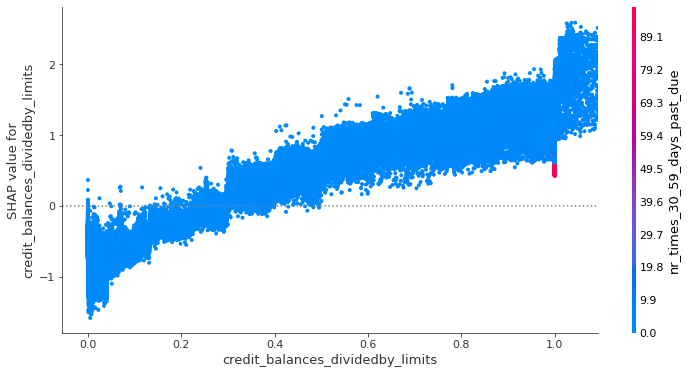

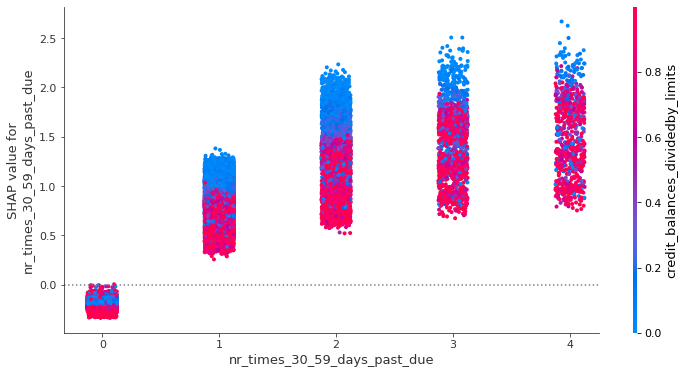

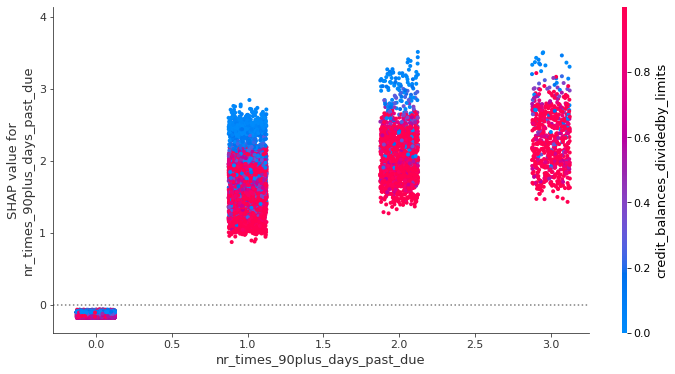

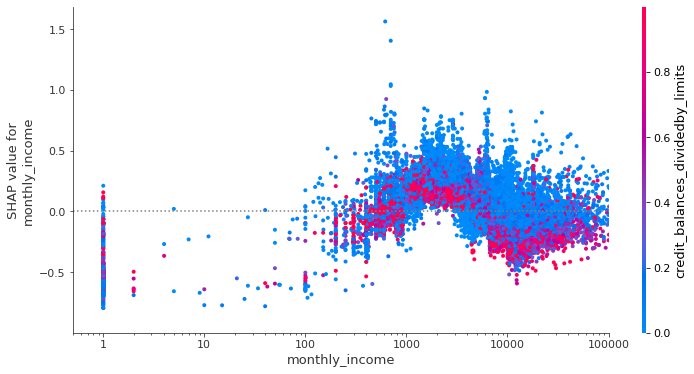

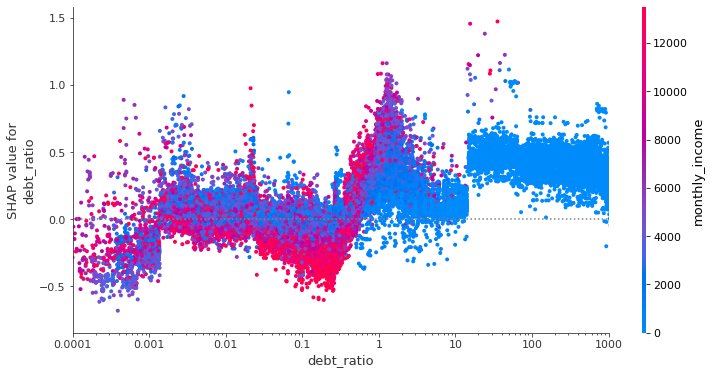

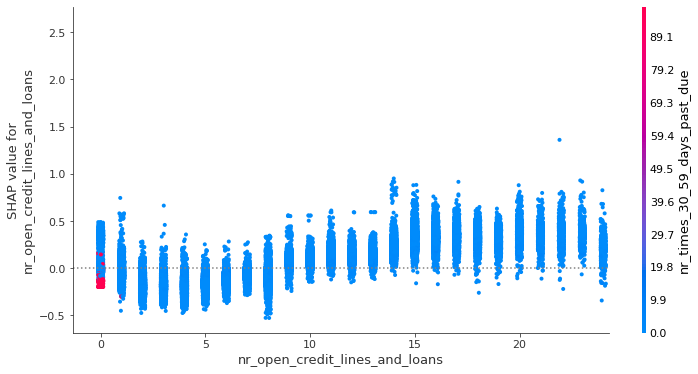

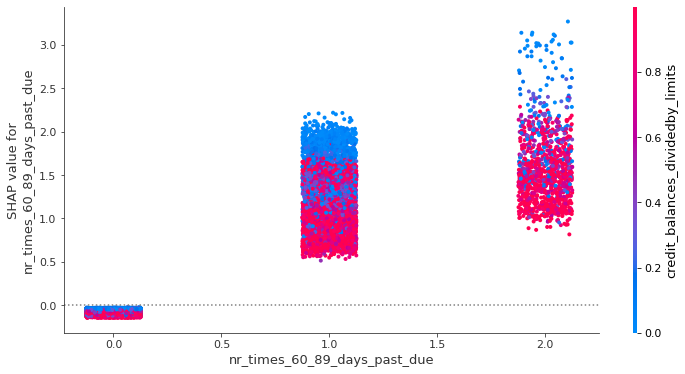

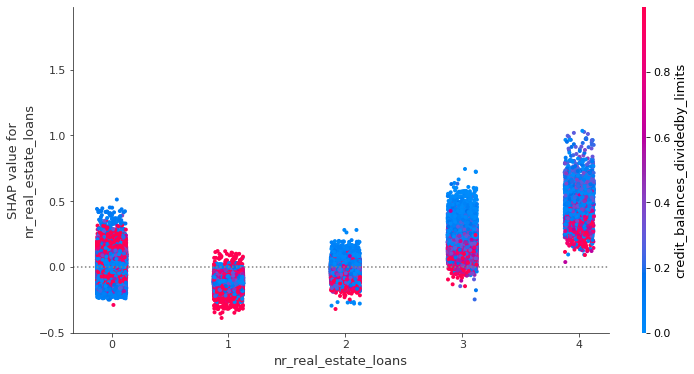

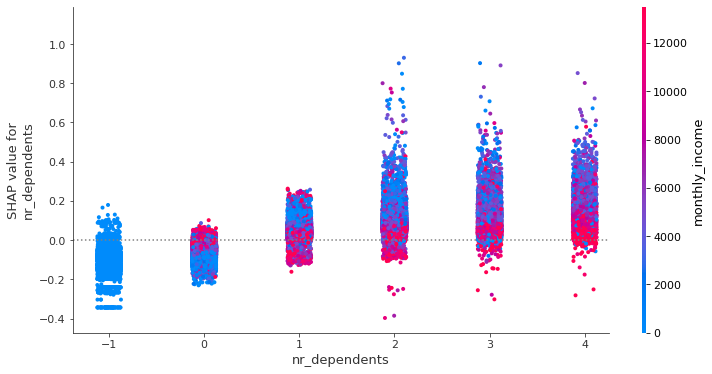

In [47]:
for i,f in enumerate(list(feature_relevance_sort.index)):
    ax = plt.figure(figsize=(12, 6)).gca()
    
    xmax = np.percentile(expl_x[f].dropna(), 99.); # plt.xlim(right=xmax)
    xmin = None if f != 'rendimento_mensal_disponivel' else -500
    
    few_unique_values = expl_x[f][expl_x[f] <= xmax].nunique() < 30
    
    x_jitter = 0
    if few_unique_values:
        x_jitter = 0.25
    
    shap.dependence_plot(f, shap_df.values, expl_x, show=False, ax=ax, xmin=xmin, xmax=xmax, x_jitter=x_jitter)
    plt.axhline(y=0, ls=':', c='grey')
    
    if few_unique_values:
        xl = plt.xlim()
        plt.xlim(xl[0], xl[1] + 0.25)
    
    if f == 'monthly_income':
        plt.xscale('log')
        plt.xlim(1e0/2, 1e5)
    if f == 'debt_ratio':
        plt.xscale('log')
        plt.xlim(1e-4, 1e3)
    if f in ['monthly_income', 'debt_ratio']:
        plt.gca().get_xaxis().set_major_formatter(matplotlib.ticker.FormatStrFormatter('%g'))
        # https://matplotlib.org/stable/api/ticker_api.html#matplotlib.ticker.FormatStrFormatter
    
    #plt.savefig(savepath + 'shap dependence_plot (%02d) %s.png' % (i, f), dpi=150) # , bbox_inches='tight'

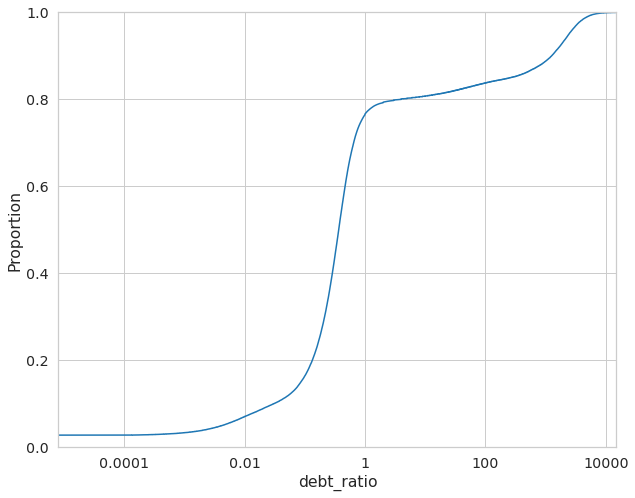

In [52]:
# tweaking the log-scales of features with wide ranges, but dense concentrations around specific low values

with sns.axes_style("whitegrid"), sns.plotting_context('notebook', font_scale=1.3):
    
    #f = 'credit_balances_dividedby_limits'
    f = 'debt_ratio'
    #f = 'monthly_income'
    X[f].sort_values()
    sns.ecdfplot(X[f])
    plt.xscale('log')

    #shap.dependence_plot(f, shap_df.values, expl_x, show=False)

    #plt.xscale('log')
    #plt.xlim(1e0/2, 1e5)
    plt.xlim(xmax=15000)

    plt.gca().get_xaxis().set_major_formatter(matplotlib.ticker.FormatStrFormatter('%g'))

-----

-----

---